### Savgol filtering and processing

#### Imports and folder selection

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import tkinter as tk
from tkinter import filedialog
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import lmfit as lm
# import mpld3
# mpld3.enable_notebook()
from scipy.fft import fft       
from scipy.fft import ifft
import scipy as scipy
import struct
import os
from pathlib import Path
from datetime import datetime
from scipy.stats import linregress
import nmrduino_util as zf
from ipywidgets import FloatSlider, interact
from scipy.linalg import hankel, svd
from glob import glob
path = zf.select_folder()
print("CurrentExperiment: "+ path)
scan_count = zf.scan_number_extraction(path)
print("Total Scans: "+ str(scan_count))

CurrentExperiment: F:/Data/tertbutylamine_new_5700/
Total Scans: 0


#### Load Experiment Data

In [2]:
#Raw Data
scans = 0
if scans == 0:
    # Checks if path exists
    compiled_path = path+"/halp_compiled"
    if os.path.exists(compiled_path+".npy"):
        halp, sampling_rate, acq_time = [np.load(compiled_path+".npy"),np.load(path+"/sampling_rate_compiled.npy"),np.load(path+"/acq_time_compiled.npy")]
    else:
        compiled_scans = zf.nmrduino_dat_interp(path,0)
        np.save(path+"/halp_compiled",compiled_scans[0])
        np.save(path+"/sampling_rate_compiled",compiled_scans[1])
        np.save(path+"/acq_time_compiled",compiled_scans[2])
        time_axis = np.linspace(0,compiled_scans[2],len(compiled_scans[0]))
        time_domain_csv = np.vstack((time_axis,compiled_scans[0]))
        np.savetxt(path+"/halp_csv",time_domain_csv,delimiter=",")
        halp, sampling_rate, acq_time = compiled_scans
else:
    halp, sampling_rate, acq_time = zf.nmrduino_dat_interp(path,scans)
print("Acquisition Time: " + str(acq_time))
print("Sampling Rate: "+str(sampling_rate))
print(scans)

Acquisition Time: 16.37875
Sampling Rate: 4000
0


### Savgol Filtering + Processing

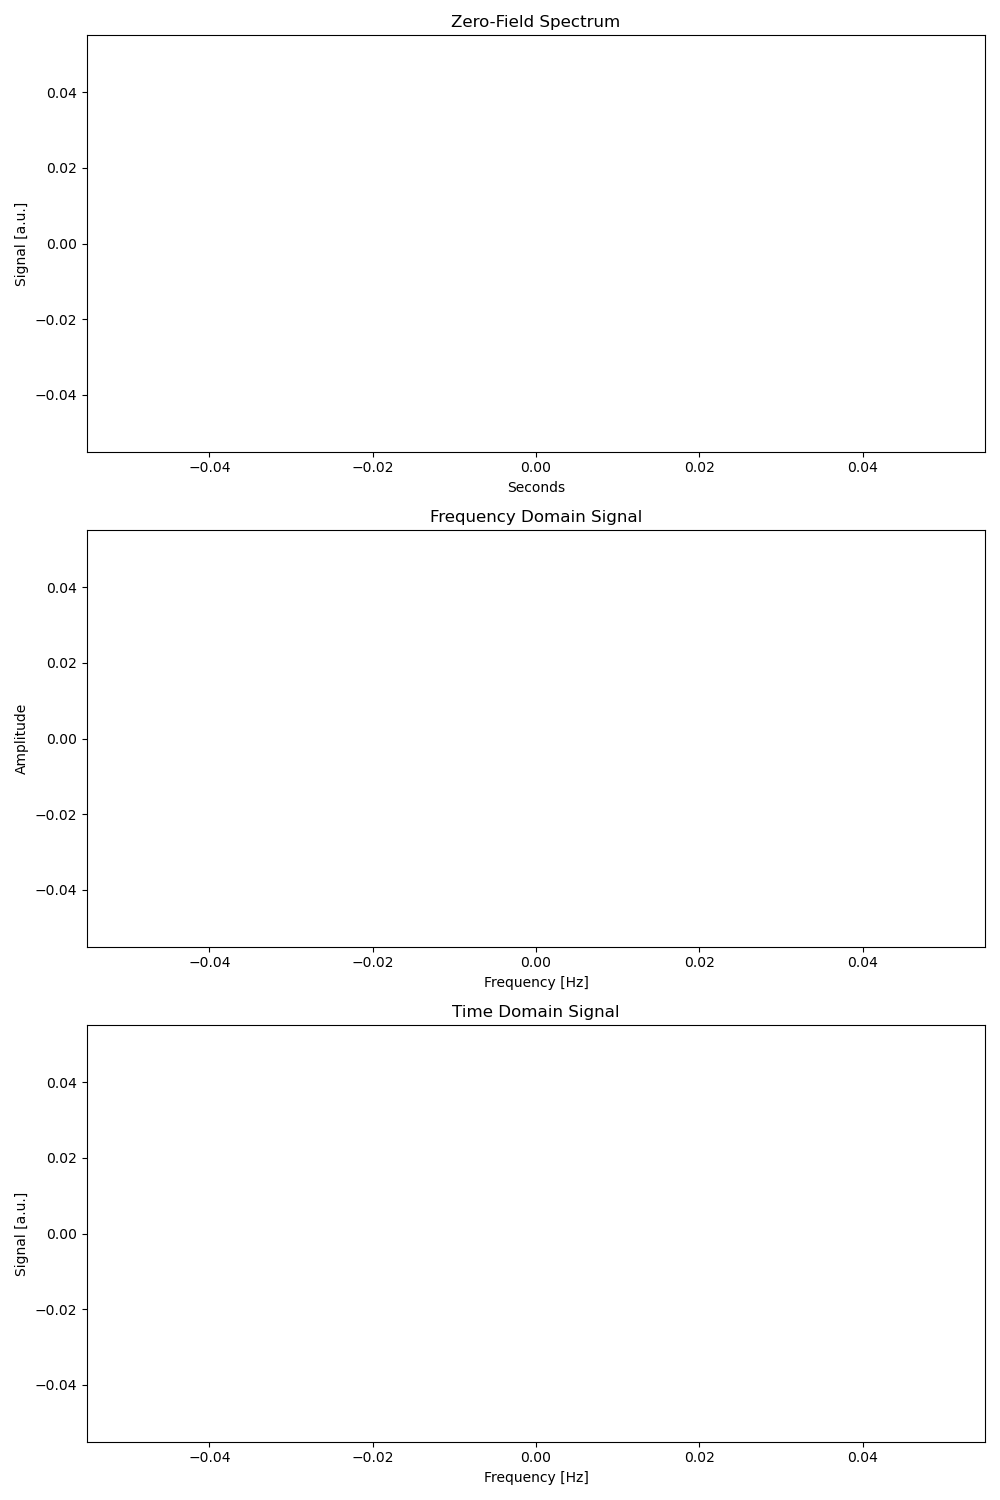

interactive(children=(FloatSlider(value=2.7, description='Zero Filling Factor', max=10.0, readout_format='.5f'…

<function __main__.u_know_how_i_do_it(a, b, c, d, e, f, g)>

In [4]:
%matplotlib widget

# Checking and importing saved filtering/processing parameters
if os.path.exists(path+"savgol_filter_save/zf_factor_stored.npy"):
    zf_factor_stored = np.load(path+"/savgol_filter_save/zf_factor_stored.npy")
    hanning_stored = np.load(path+"/savgol_filter_save/hanning_stored.npy")
    conv_points_stored = np.load(path+"/savgol_filter_save/conv_points_stored.npy")
    poly_order_stored = np.load(path+"/savgol_filter_save/poly_order_stored.npy")
    trunc_stored = np.load(path+"/savgol_filter_save/trunc_stored.npy")
    trunc_f_stored = np.load(path+"/savgol_filter_save/trunc_f_stored.npy")
    apod_stored = np.load(path+"/savgol_filter_save/apod_stored.npy")
else:
    zf_factor_stored = 0
    hanning_stored = 0
    conv_points_stored = 300
    poly_order_stored = 2
    trunc_stored = 10
    trunc_f_stored = 10
    apod_stored = 0
    print("No stored values found")

# Here is where you toggle whether you want to save the figure as an .svg in your current experiment folder.
save_figure = False # This will save every time the sliders are interacted with.
name = "benzene_9_4_25" # name identifier

# Creating figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
line, = ax1.plot([], [],"k",linewidth=0.5)
line_2, = ax2.plot([], [],"k",linewidth=0.5)
line_3, = ax3.plot([], [],"k",linewidth=0.5)
ax1.set_title("Zero-Field Spectrum")
ax1.set_ylabel("Signal [a.u.]")
ax1.set_xlabel("Seconds")

ax2.set_title("Frequency Domain Signal")
ax2.set_ylabel("Amplitude")
ax2.set_xlabel("Frequency [Hz]")

ax3.set_title("Time Domain Signal")
ax3.set_ylabel("Signal [a.u.]")
ax3.set_xlabel("Frequency [Hz]")
plt.tight_layout()



plt.show()

# Frequency range of subplots
frequency_range_1 = [0,30]
frequency_range = [100,275]

# Filtering/processing function with slider interactivity
def u_know_how_i_do_it(a,b,c,d,e,f,g):
        # Savgol Filtering
    smooth_svd = scipy.signal.savgol_filter(halp, int(float(c)),int(float(d)), mode="mirror")
    svd_corrected = (halp - smooth_svd)
        #Time Domain Truncation
    svd_corrected = svd_corrected[int(e):-int(f)]
    acq_time_effective = acq_time*(len(svd_corrected)/len(halp))
            #Apodization
    t = np.linspace(0, acq_time_effective, len(svd_corrected))
    apodization_window = np.exp(-g * t)
    svd_corrected = svd_corrected * apodization_window
        #Hanning window:
    if int(float(b)) == 1:
        svd_corrected = np.hanning(len(svd_corrected))*svd_corrected
        #Zero Filling
    svd_corrected = np.concatenate((svd_corrected,np.ones(int(float(len(svd_corrected)*a)))*np.mean(svd_corrected)))
    ###################
    yf_phased = fft(svd_corrected)
    xf = np.linspace(0,sampling_rate,len(yf_phased))
    index_peak_i = np.where(xf >= frequency_range[0])[0][0]
    index_peak_f = np.where(xf >= frequency_range[1])[0][0]
    max_val_ini = max(np.abs(yf_phased[index_peak_i:index_peak_f]))
    yf_phased = fft(svd_corrected)#/max_val_ini
    index_peak_i = np.where(xf >= frequency_range[0])[0][0]
    index_peak_f = np.where(xf >= frequency_range[1])[0][0]
    max_val = max(np.abs(yf_phased[index_peak_i:index_peak_f]))
    min_val = min(np.abs(yf_phased[index_peak_i:index_peak_f]))
    ax3.set_xlim(frequency_range)
    ax3.set_ylim(min_val,max_val)
    line_3.set_xdata(xf)
    line_3.set_ydata(np.abs(yf_phased))#/max_val)
    line_2.set_xdata(xf)
    line_2.set_ydata(np.abs(yf_phased))#/max_val)
    index_peak_i = np.where(xf >= frequency_range_1[0])[0][0]
    index_peak_f = np.where(xf >= frequency_range_1[1])[0][0]
    max_val_1 = max(np.abs(yf_phased[index_peak_i:index_peak_f][10:]))
    min_val_1 = min(np.abs(yf_phased[index_peak_i:index_peak_f]))
    ax2.set_xlim(frequency_range_1)
    ax2.axes.set_ylim(min_val_1-max_val_1*.3,max_val_1+max_val_1*.3)
    line.set_ydata(svd_corrected)
    line.set_xdata(np.linspace(0,acq_time*(1+(a)),len(svd_corrected)))
    ax1.set_xlim(0,acq_time*(1+(a)))
    ax1.set_ylim(np.min(svd_corrected),np.max(svd_corrected))
    frequency_range_snr = [11,14]
    noise_range_snr = [350,400]
    if save_figure:
        import os
        filename = f"{name}_savgol_filtered_{frequency_range}_{frequency_range_1}.svg"
        fig.savefig(os.path.join(path, filename))
        np.save(os.path.join(path, f"{name}_frequency.npy"), xf)
        np.save(os.path.join(path, f"{name}_amplitude.npy"), yf_phased)
    
    try:
        snr_result = zf.snr_calc(xf, np.abs(yf_phased), frequency_range_snr, noise_range_snr) / np.sqrt(zf.scan_number_extraction(path))
        print(f"SNR: {snr_result}")
    except Exception as e:
        print(f"SNR calculation error: {e}")

# Intializing sliders
zf_slider = FloatSlider(value= zf_factor_stored, min=0, max=10, step=.01, description='Zero Filling Factor', readout_format='.5f')
hanning_slider = FloatSlider(value= hanning_stored, min=0, max=1, step=1, description='Hanning T/F', readout_format='.5f')
conv_slider = FloatSlider(value=conv_points_stored, min=2, max=12000, step=1, description='Convolution Points', readout_format='.7f')
poly_slider = FloatSlider(value=poly_order_stored, min=1, max=20, step=1, description='Poly Order', readout_format='.7f')
trunc_slider = FloatSlider(value=trunc_stored, min=1, max=8000, step=1, description='Trunc Points', readout_format='.7f')
trunc_f_slider = FloatSlider(value=trunc_f_stored, min=1, max=60000, step=1, description='Trunc f Points', readout_format='.7f')
apodization_slider = FloatSlider(value=apod_stored, min=-2, max=2, step=.01, description='Apodization T2*', readout_format='.5f')
# Use `interact` to link the slider and the plotting function
interact(u_know_how_i_do_it, a=zf_slider, b = hanning_slider, c = conv_slider, d = poly_slider, e = trunc_slider, f=trunc_f_slider, g=apodization_slider)

#### Saving Progress Savgol + Processing

In [9]:
import os; os.makedirs(os.path.join(path, "savgol_filter_save"), exist_ok=True)
# The value below will be saved, if another value is saved, it will be overwritten when this cell is ran:
zf_factor_stored = 2.7
hanning_stored = 0
conv_points_stored = 922
poly_order_stored = 2
trunc_stored = 2000
trunc_f_stored = 27922
apod_stored = 0.75
np.save(path+"/savgol_filter_save/zf_factor_stored",zf_factor_stored)
np.save(path+"/savgol_filter_save/hanning_stored",hanning_stored)
np.save(path+"/savgol_filter_save/conv_points_stored",conv_points_stored)
np.save(path+"/savgol_filter_save/poly_order_stored",poly_order_stored)
np.save(path+"/savgol_filter_save/trunc_stored",trunc_stored)
np.save(path+"/savgol_filter_save/trunc_f_stored",trunc_f_stored)
np.save(path+"/savgol_filter_save/apod_stored",apod_stored)

### Saving plots as svgs

In [9]:
%matplotlib widget
if os.path.exists(path+"savgol_filter_save/zf_factor_stored.npy"):
    zf_factor_stored = np.load(path+"/savgol_filter_save/zf_factor_stored.npy")
    hanning_stored = np.load(path+"/savgol_filter_save/hanning_stored.npy")
    conv_points_stored = np.load(path+"/savgol_filter_save/conv_points_stored.npy")
    poly_order_stored = np.load(path+"/savgol_filter_save/poly_order_stored.npy")
    trunc_stored = np.load(path+"/savgol_filter_save/trunc_stored.npy")
    trunc_f_stored = np.load(path+"/savgol_filter_save/trunc_f_stored.npy")
    apod_stored = np.load(path+"/savgol_filter_save/apod_stored.npy")
else:
    print("No stored values found")
save_figure = True
name = "formic_acid_final"
halp_trunc_f = halp[:(len(halp)-int(float(np.load(path+"/time_domain_trunc_save/stored_trunc_factor.npy")*len(halp))))]
halp = halp_trunc_f
acq_time = acq_time*(len(halp_trunc_f)/len(halp))
sampling_rate = sampling_rate
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# Initialize lines for each subplot
line, = ax1.plot([], [])
line_2, = ax2.plot([], [])
line_3, = ax3.plot([], [])

ax1.set_title("Truncated Acquisition Signal (Back Trimmed)"+ str(frequency_range))
ax1.set_ylabel("Signal [a.u.]")
ax1.set_xlabel("Seconds")

ax2.set_title("Frequency Domain Signal"+ str(frequency_range_1))
ax2.set_ylabel("Amplitude")
ax2.set_xlabel("Frequency [Hz]")

ax3.set_title("Apodized Time Domain Signal")
ax3.set_ylabel("Signal [a.u.]")
ax3.set_xlabel("Seconds")

plt.tight_layout()
plt.show()
frequency_range = [.55,5]#[160,220]
frequency_range_1 = [0,300]
def u_know_how_i_do_it_1(a,b,c,d,e,f,g):
        # Savgol Filtering
    smooth_svd = scipy.signal.savgol_filter(halp, int(float(c)),int(float(d)), mode="mirror")
    svd_corrected = (halp - smooth_svd)
        #Time Domain Truncation
    svd_corrected = svd_corrected[int(e):-int(f)]
    acq_time_effective = acq_time*(len(svd_corrected)/len(halp))
            #Apodization
    t = np.linspace(0, acq_time_effective, len(svd_corrected))
    apodization_window = np.exp(-g * t)
    svd_corrected = svd_corrected * apodization_window
        #Hanning window:
    if int(float(b)) == 1:
        svd_corrected = np.hanning(len(svd_corrected))*svd_corrected
        #Zero Filling
    svd_corrected = np.concatenate((svd_corrected,np.ones(int(float(len(svd_corrected)*a)))*np.mean(svd_corrected)))
    ###################
    yf_phased = fft(svd_corrected)
    xf = np.linspace(0,sampling_rate,len(yf_phased))
    index_peak_i = np.where(xf >= frequency_range[0])[0][0]
    index_peak_f = np.where(xf >= frequency_range[1])[0][0]
    max_val_ini = max(np.abs(yf_phased[index_peak_i:index_peak_f]))
    yf_phased = fft(svd_corrected)#/max_val_ini
    index_peak_i = np.where(xf >= frequency_range[0])[0][0]
    index_peak_f = np.where(xf >= frequency_range[1])[0][0]
    max_val = max(np.abs(yf_phased[index_peak_i:index_peak_f]))
    min_val = min(np.abs(yf_phased[index_peak_i:index_peak_f]))
    ax1.set_xlim(frequency_range)
    ax1.set_ylim(min_val-.1*max_val,max_val*1.1)
    line.set_xdata(xf)
    line.set_ydata(np.abs(yf_phased))#/(2*max_val)+ max_val*.2)
    line_2.set_xdata(xf)
    line_2.set_ydata(np.abs(yf_phased))#/max_val)
    index_peak_i = np.where(xf >= frequency_range_1[0])[0][0]
    index_peak_f = np.where(xf >= frequency_range_1[1])[0][0]
    max_val_1 = max(np.abs(yf_phased[index_peak_i:index_peak_f]))
    min_val_1 = min(np.abs(yf_phased[index_peak_i:index_peak_f]))
    ax2.set_xlim(frequency_range_1)
    ax2.axes.set_ylim(min_val_1-min_val_1*.3,max_val_1+max_val_1*.3)
    bandpass_halp, bandpass_acqtime = zf.bandpass_data(svd_corrected,sampling_rate,acq_time,freq_range=frequency_range_1)
    line_3.set_ydata(bandpass_halp)
    line_3.set_xdata(np.linspace(0,acq_time,len(bandpass_halp)))
    ax3.set_xlim(np.linspace(0,acq_time,len(svd_corrected))[0],np.linspace(0,acq_time,len(svd_corrected))[-1])
    ax3.set_ylim(np.min(svd_corrected),np.max(svd_corrected))
    fig.savefig(path+name+"_savgol_filtered"+str(frequency_range)+str(frequency_range_1)+".svg")
    return xf, yf_phased
xf_test, yf_test = u_know_how_i_do_it_1(zf_factor_stored,hanning_stored,conv_points_stored,poly_order_stored,trunc_stored,trunc_f_stored,apod_stored)
fig.savefig(path+name+"_savgol_filtered"+str(frequency_range)+str(frequency_range_1)+".svg")
np.save(path+name+"_savgol_filtered_xf.npy",xf_test)
np.save(path+name+"_savgol_filtered_yf.npy",yf_test)
# plt.figure()
# plt.plot(xf_test,yf_test)
# plt.show()

RuntimeError: 'widget is not a recognised GUI loop or backend name

#### Absolute Value Lorentzian Fitting

In [5]:
%matplotlib widget
from scipy.optimize import curve_fit
if os.path.exists(path+"savgol_filter_save/zf_factor_stored.npy"):
    zf_factor_stored = np.load(path+"/savgol_filter_save/zf_factor_stored.npy")
    hanning_stored = np.load(path+"/savgol_filter_save/hanning_stored.npy")
    conv_points_stored = np.load(path+"/savgol_filter_save/conv_points_stored.npy")
    poly_order_stored = np.load(path+"/savgol_filter_save/poly_order_stored.npy")
    trunc_stored = np.load(path+"/savgol_filter_save/trunc_stored.npy")
    trunc_f_stored = np.load(path+"/savgol_filter_save/trunc_f_stored.npy")
    apod_stored = np.load(path+"/savgol_filter_save/apod_stored.npy")
else:
    print("No stored values found")
name = "acetic_acid_226"
halp_trunc_f = halp[:(len(halp)-int(float(np.load(path+"/time_domain_trunc_save/stored_trunc_factor.npy")*len(halp))))]
halp = halp_trunc_f
acq_time = acq_time*(len(halp_trunc_f)/len(halp))
sampling_rate = sampling_rate
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# Initialize lines for each subplot
line, = ax1.plot([], [])
line_2, = ax2.plot([], [])
line_3, = ax3.plot([], [])

ax1.set_title("Truncated Acquisition Signal (Back Trimmed)"+ str(frequency_range))
ax1.set_ylabel("Signal [a.u.]")
ax1.set_xlabel("Seconds")

ax2.set_title("Frequency Domain Signal"+ str(frequency_range_1))
ax2.set_ylabel("Amplitude")
ax2.set_xlabel("Frequency [Hz]")

ax3.set_title("Apodized Time Domain Signal")
ax3.set_ylabel("Signal [a.u.]")
ax3.set_xlabel("Seconds")

plt.tight_layout()
plt.show()
frequency_range = [150-12.5,150+12.5]#[160,220]
frequency_range_1 = [135,178]
def u_know_how_i_do_it_1(a,b,c,d,e,f,g):
        # Savgol Filtering
    smooth_svd = scipy.signal.savgol_filter(halp, int(float(c)),int(float(d)), mode="mirror")
    svd_corrected = (halp - smooth_svd)
        #Time Domain Truncation
    svd_corrected = svd_corrected[int(e):-int(f)]
    acq_time_effective = acq_time*(len(svd_corrected)/len(halp))
            #Apodization
    t = np.linspace(0, acq_time_effective, len(svd_corrected))
    apodization_window = np.exp(-g * t)
    svd_corrected = svd_corrected * apodization_window
        #Hanning window:
    if int(float(b)) == 1:
        svd_corrected = np.hanning(len(svd_corrected))*svd_corrected
        #Zero Filling
    svd_corrected = np.concatenate((svd_corrected,np.ones(int(float(len(svd_corrected)*a)))*np.mean(svd_corrected)))
    ###################
    yf_phased = fft(svd_corrected)
    xf = np.linspace(0,sampling_rate,len(yf_phased))
    index_peak_i = np.where(xf >= frequency_range[0])[0][0]
    index_peak_f = np.where(xf >= frequency_range[1])[0][0]
    max_val_ini = max(np.abs(yf_phased[index_peak_i:index_peak_f]))
    yf_phased = fft(svd_corrected)#/max_val_ini
    yf_lorentz = yf_phased[index_peak_i:index_peak_f]
    xf_lorentz = xf[index_peak_i:index_peak_f]
######## Lorentzian fitting ########
    def lorentzian_1d(x, amplitude, center, width):
        return amplitude / (1 + ((x - center) / (width/2))**2)
    
    def abs_lorentzian_linear(x, amplitude, center, width, slope, intercept):
        return np.abs(lorentzian_1d(x, amplitude, center, width)) + slope * x + intercept

    # Example: If you have your data as xf_test and yf_test (from your workflow)
    # x_data = xf_test
    # y_data = np.abs(yf_test)

    # Initial guess for parameters: [amplitude, center, width, slope, intercept]
    p0 = [np.max(np.abs(yf_lorentz)), xf_lorentz[np.argmax(yf_lorentz)], 1, 0, np.min(np.abs(yf_lorentz))]

    # Fit
    popt, pcov = curve_fit(abs_lorentzian_linear, xf_lorentz, np.abs(yf_lorentz), p0=p0, maxfev=10000)
    index_peak_i = np.where(xf >= frequency_range[0])[0][0]
    index_peak_f = np.where(xf >= frequency_range[1])[0][0]
    max_val = max(np.abs(yf_phased[index_peak_i:index_peak_f]))
    min_val = min(np.abs(yf_phased[index_peak_i:index_peak_f]))
    ax1.set_xlim(frequency_range)
    ax1.set_ylim(-10,max_val+10)
    ax1.plot(xf_lorentz, abs_lorentzian_linear(xf_lorentz, *popt), 'r-', label='Fitted Lorentzian')
    ax1.plot(xf_lorentz,np.abs(yf_lorentz))
    ax1.plot(xf_lorentz,lorentzian_1d(xf_lorentz, popt[0], 150, popt[2]))
    line_2.set_xdata(xf)
    line_2.set_ydata(np.abs(yf_phased))#/max_val)
    index_peak_i = np.where(xf >= frequency_range_1[0])[0][0]
    index_peak_f = np.where(xf >= frequency_range_1[1])[0][0]
    max_val_1 = max(np.abs(yf_phased[index_peak_i:index_peak_f]))
    min_val_1 = min(np.abs(yf_phased[index_peak_i:index_peak_f]))
    ax2.set_xlim(frequency_range_1)
    ax2.axes.set_ylim(min_val_1-min_val_1*.3,max_val_1+max_val_1*.3)
    bandpass_halp, bandpass_acqtime = zf.bandpass_data(svd_corrected,sampling_rate,acq_time,freq_range=frequency_range_1)
    line_3.set_ydata(bandpass_halp)
    line_3.set_xdata(np.linspace(0,acq_time,len(bandpass_halp)))
    ax3.set_xlim(np.linspace(0,acq_time,len(svd_corrected))[0],np.linspace(0,acq_time,len(svd_corrected))[-1])
    ax3.set_ylim(np.min(svd_corrected),np.max(svd_corrected))
    return xf, yf_phased
xf_test, yf_test = u_know_how_i_do_it_1(zf_factor_stored,hanning_stored,conv_points_stored,poly_order_stored,trunc_stored,trunc_f_stored,apod_stored)
fig.savefig(path+name+"_savgol_filtered"+str(frequency_range)+str(frequency_range_1)+".svg")

RuntimeError: 'widget is not a recognised GUI loop or backend name

#### Saving Progress (Savgol Filtering + Processing)

In [6]:
import os; os.makedirs(os.path.join(path, "savgol_filter_save"), exist_ok=True)
# The value below will be saved, if another value is saved, it will be overwritten when this cell is ran:
zf_factor_stored = 3.44
hanning_stored = 1
conv_points_stored = 1526
poly_order_stored = 4.0000000
trunc_stored = 18
trunc_f_stored = 1
apod_stored = .56
np.save(path+"/savgol_filter_save/zf_factor_stored",zf_factor_stored)
np.save(path+"/savgol_filter_save/hanning_stored",hanning_stored)
np.save(path+"/savgol_filter_save/conv_points_stored",conv_points_stored)
np.save(path+"/savgol_filter_save/poly_order_stored",poly_order_stored)
np.save(path+"/savgol_filter_save/trunc_stored",trunc_stored)
np.save(path+"/savgol_filter_save/trunc_f_stored",trunc_f_stored)
np.save(path+"/savgol_filter_save/apod_stored",apod_stored)

#### Saving Savgol (Checkpoint)

In [ ]:
%matplotlib widget
zero_fill_factor = 3
np.save(path+"/savgol.npy",svd_corrected_f)
test_savgol = np.load(path+"/savgol.npy")
yf_savgol_test = np.abs(fft(svd_corrected_f))
xf_savgol_test = np.linspace(0,sampling_rate,len(yf_savgol_test))
hanning_savgol = np.zeros(len(test_savgol)*zero_fill_factor)
hanning_savgol[:len(test_savgol)] = test_savgol
hanning_savgol[len(test_savgol):] = np.mean(test_savgol)
yf_hanning = np.abs(fft(hanning_savgol))
xf_hanning = np.linspace(0,sampling_rate,len(yf_hanning))
plt.figure()
plt.plot(xf_hanning,yf_hanning+100, "k", linewidth = .5)
#plt.plot(xf_savgol_test,yf_savgol_test)
plt.xlim(5,31)
plt.ylim(0,np.max(yf_hanning))
plt.show()
plt.savefig(path+"/final_plot_2_12_25_inset_5_31.svg",format="svg")

#### Linear Phase Correction

In [ ]:
acq_time = acq_time_trunc_f
sampling_rate = sampling_rate
lin_phase_stored = -203.0000000
const_phase_stored = 0.00000000
plt.figure()
line, = plt.plot([1,2,3],[4,5,6])
plt.show()
plt.figure()
line_2, = plt.plot([1,2,3],[4,5,6])
line_3, = plt.plot([1,2,3],[4,5,6])
plt.show()
frequency_range = [0,200]
frequency_range_1 = [140,185]
def plot_zf_linear_phase(a,b):
    ########################################
    # Phasing (irrelevant for absolute value spectra)
    ########################################
    lin_phase = np.linspace(np.pi*a,-np.pi*a,len(test_savgol))
    # lin_phase_applied = test_savgol*np.exp(1j*lin_phase)
    # const_phase_applied = lin_phase_applied*np.exp(-1j*b)
    yf_phased = fft(test_savgol)*np.exp(1j*lin_phase)*np.exp(-1j*b)
    xf = np.linspace(0,sampling_rate,len(yf_phased))
    line.set_xdata(xf)
    line.set_ydata(np.real(yf_phased))
    index_peak_i = np.where(xf >= frequency_range[0])[0][0]
    index_peak_f = np.where(xf >= frequency_range[1])[0][0]
    max_val = max(np.real(yf_phased[index_peak_i:index_peak_f]))
    min_val = min(np.real(yf_phased[index_peak_i:index_peak_f]))
    line.axes.set_xlim(frequency_range)
    line.axes.set_ylim(min_val,max_val)
    line_2.set_xdata(xf)
    line_2.set_ydata(np.real(yf_phased))
    index_peak_i = np.where(xf >= frequency_range_1[0])[0][0]
    index_peak_f = np.where(xf >= frequency_range_1[1])[0][0]
    max_val_1 = max(np.real(yf_phased[index_peak_i:index_peak_f]))
    min_val_1 = min(np.real(yf_phased[index_peak_i:index_peak_f]))
    line_2.axes.set_xlim(frequency_range_1)
    line_2.axes.set_ylim(-1300,700)#min_val_1*1.5,max_val_1*1.5)
    line_3.set_ydata(np.abs(yf_phased)-1000)
    line_3.set_xdata(xf)
lin_slider = FloatSlider(value=lin_phase_stored, min=-10000, max=10000, step=1, description='Linear', readout_format='.7f')
const_slider = FloatSlider(value=const_phase_stored, min=0, max=2, step=.01, description='Constant', readout_format='.7f')
# Use `interact` to link the slider and the plotting function
interact(plot_zf_linear_phase, a=lin_slider, b =const_slider)
########################
# Here's where we actually apply the changed with the stored values above:
########################
# smooth_svd_f = scipy.signal.savgol_filter(svd_filtered, int(float(conv_points_stored)),int(float(poly_order_stored)))
# svd_corrected_f = (svd_filtered - smooth_svd_f)[int(trunc_stored):]
# lin_phase_F = np.linspace(np.pi*-203.0000000,-np.pi*-203.0000000,len(svd_filtered))
# yf_FINAL = np.abs(fft(svd_corrected_f))
# xf_FINAL = np.linspace(0,sub_sampling_rate_f,len(yf_FINAL))
# plt.figure()
# plt.plot(xf_FINAL,yf_FINAL)
# plt.show()

In [ ]:
%matplotlib widget
abs_final = np.vstack((xf_FINAL,yf_FINAL))Figure 28
Figure 29
Figure 30
Linear
1.0000000
Constant
0.0000000
Convolution Points
693.0000000
Poly Order
4.0000000
Trunc Points
440.0000000
Figure 31
Figure

Figure

Figure 1
Figure 1
Subsampling Factor:
3.0
<class 'int'>
Old Sampling Rate: 8333
New Sampling Rate: 2777.6666666666665
Old Acquisition Time: 7.862114484579383
New Acquisition Time: 7.861994479779191
Old Length: 65515
New Length: 21838
Nyquist Frequency: 1388.8333333333333
Peak height = (756.2813293775107+2064.134881112722j)
SNR = (114.39726209433891+108.36441563080167j)
<class 'int'>
Old Sampling Rate: 8333
New Sampling Rate: 2777.6666666666665
Old Acquisition Time: 7.862114484579383
New Acquisition Time: 7.861994479779191
Old Length: 65515
New Length: 21838
Nyquist Frequency: 1388.8333333333333
Peak height = (756.2813293775107+2064.134881112722j)
SNR = (114.39726209433891+108.36441563080167j)
c:\Users\blake\anaconda3\envs\zulf\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\blake\anaconda3\envs\zulf\Lib\site-packages\matplotlib\transforms.py:2872: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
c:\Users\blake\anaconda3\envs\zulf\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\blake\anaconda3\envs\zulf\Lib\site-packages\matplotlib\transforms.py:2872: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
<class 'int'>
Figure 2
21838
Truncation Fraction
0.1500000
New acq_time: 6.682947317892716s
New acq_time: 6.682947317892716s
Figure 1
(x, y) = (141.4, −549.)
Figure 1
(x, y) = (141.4, −549.)
New Datalength: 18563
New Datalength: 18563
New acq_time: 6.682947317892716s
Figure 1
Figure 2
(x, y) = (−16.4, −2.48e+04)
datalength : 18563
(18553, 18553) (18553,) (18553, 18553)
Is self adjoint? True
18553
C:\Users\blake\AppData\Local\Temp\ipykernel_33180\3472304402.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  yf_full[:len(yf)] = yf
Figure 2
Figure 3
Figure 5
Figure 6
(x, y) = (1.336e+04, 7.13e+03)
7
Figure 4
Figure 7
Could not render content for 'application/vnd.jupyter.widget-view+json'
{"model_id":"e480be39305645e9af316559d367b41e","version_major":2,"version_minor":0}
Could not render content for 'application/vnd.jupyter.widget-view+json'
{"model_id":"ac1a2f94049940b4ba3fd35ebf4960b5","version_major":2,"version_minor":0}
Could not render content for 'application/vnd.jupyter.widget-view+json'
{"model_id":"8694073ffd954e16b31f33c063f93ba5","version_major":2,"version_minor":0}
Could not render content for 'application/vnd.jupyter.widget-view+json'
{"model_id":"51f062abb8d14a8fa7ec16a4104b4a57","version_major":2,"version_minor":0}
<function __main__.smooth(a, b, c)>
Could not render content for 'application/vnd.jupyter.widget-view+json'
{"model_id":"e86cada2b0e6400786cc27f92204eb04","version_major":2,"version_minor":0}
Figure 1

plt.figure()
plt.plot(abs_final[0],np.abs(abs_final[1]))
plt.show()
np.save(path+"/abs.npy",abs_final)

In [ ]:
abs_test = np.load(path+"/abs.npy")
plt.figure()
plt.plot(abs_test[0],np.abs(abs_test[1]))
plt.show()

In [ ]:
%matplotlib widget
stored_trunc_i = 1
stored_trunc_f = 1
plt.figure()
plt.title("Filtered Spectrum")
line1, = plt.plot([1,2,3],[4,5,6])
plt.show()
plt.figure()
line2, = plt.plot([1,2,3],[4,5,6])
plt.title("Truncated Halp")
plt.show()
def trun(a,b):
    new_halp_plot = new_halp[int(a):-int(b)]
    yf=fft(new_halp_plot)
    line1.set_xdata(np.linspace(0,sampling_rate,len(yf)))
    line1.set_ydata(np.real(yf))
    line1.axes.set_xlim([0,sampling_rate/2])
    line1.axes.set_ylim([min(np.real(yf)),max(np.real(yf))])
    line2.set_xdata(np.linspace(0,len(new_halp_plot),len(new_halp_plot)))
    line2.set_ydata(new_halp_plot)
    line2.axes.set_xlim([0,len(new_halp_plot)])
    line2.axes.set_ylim([min(new_halp_plot),max(new_halp_plot)])
    # line2.set_xdata(np.linspace(0,len(new_halp_plot),len(new_halp_plot)))
    # line2.set_ydata(new_halp_plot)
slider_a = FloatSlider(value=stored_trunc_i, min=0, max=10000, step=1, description='Truncation Fraction', readout_format='.7f')
slider_b = FloatSlider(value=stored_trunc_f, min=0, max=10000, step=1, description='Truncation Fraction', readout_format='.7f')
# Use `interact` to link the slider and the plotting function
interact(trun, a=slider_a, b=slider_b)
new_halp_trunc = new_halp[stored_trunc_i:-stored_trunc_f]

#### Smoothing new halp

In [ ]:
%matplotlib widget
%matplotlib widget
##################
#stored_value_convolution_points = 100
stored_value_convolution_points = 17
stored_poly_order = 1
stored_trunc = 1
#Set 100 for 140 scans, 1000 for 2000 scans
#time_domain_trimming_back = 100
##################
plt.clf()
plt.figure()
line_fft, = plt.plot([1,2,3],[4,5,6])
plt.show()
plt.figure()
line_halp, = plt.plot([1,2,3],[4,5,6])
line_smooth, = plt.plot([1,2,3],[4,5,6])
plt.show()
plt.figure()
line_smooth_halp, = plt.plot([1,2,3],[4,5,6])
plt.show()
def smooth(a,b,c):
    smooth_halp = scipy.signal.savgol_filter(new_halp_trunc, int(float(a)),int(float(b)))
    halp_corrected = new_halp_trunc-smooth_halp
    halp_corrected = halp_corrected[:-int(float(c))] - np.mean(halp_corrected)
    yf_corrected = fft(halp_corrected)
    xf_corrected = np.linspace(0,sampling_rate,len(yf_corrected))
    line_fft.set_ydata(np.real(yf_corrected))
    line_fft.set_xdata(xf_corrected)
    line_fft.axes.set_xlim([0,sampling_rate/2])
    line_fft.axes.set_ylim([min(np.real(yf_corrected)),max(np.real(yf_corrected))])

    line_halp.set_ydata(new_halp_trunc)
    line_halp.set_xdata(np.linspace(0,acq_time_trunc_f,len(new_halp_trunc)))
    line_halp.axes.set_xlim([0,acq_time_trunc_f])
    line_halp.axes.set_ylim([min(np.real(new_halp_trunc)),max(np.real(new_halp_trunc))])
    line_smooth.set_ydata(np.real(smooth_halp))
    line_smooth.set_xdata(np.linspace(0,acq_time_trunc_f,len(smooth_halp)))
    line_smooth_halp.set_ydata(halp_corrected)
    line_smooth_halp.set_xdata(np.linspace(0,acq_time_trunc_f,len(halp_corrected)))
    line_smooth_halp.axes.set_xlim([0,acq_time_trunc_f])
    line_smooth_halp.axes.set_ylim([min(np.real(halp_corrected)),max(np.real(halp_corrected))])
conv_slider = FloatSlider(value=stored_value_convolution_points, min=2, max=5000, step=1, description='Convolution Points', readout_format='.7f')
poly_slider = FloatSlider(value=stored_poly_order, min=1, max=20, step=1, description='Poly Order', readout_format='.7f')
trunc_slider = FloatSlider(value=stored_trunc, min=1, max=20000, step=1, description='Truncated Points', readout_format='.7f')
interact(smooth, a=conv_slider, b = poly_slider, c = trunc_slider)


#### Saving Data as a numpy array in exp folder 

#### SVD loop

In [ ]:
%matplotlib widget
halp_matrix = hankel(halp_trunc_f)
U,S,V = svd(halp_matrix)
M  = np.diag(S) @ V
res = []
n = len(halp_trunc_f)
for x in range(0,300):
    sigval = x*10
    up = U[sigval, sigval:]
    res.append((up @ M[-(n-sigval):,-(n-sigval):]).copy())
    print(sigval)


In [ ]:
# Animation

import matplotlib.pyplot as plt
%matplotlib widget
from matplotlib.animation import FuncAnimation
plt.close(1)
plt.cla()
plt.clf()
fig, ax = plt.subplots(num=1)
line, = ax.plot([1,2,3],[4,5,6])
print(len(res))
def animate(i):
    i= i+1
    y_data = res[i][:-i*10]
    line.set_ydata(np.real(fft(y_data)))
    line.set_xdata(np.linspace(0,sampling_rate,len(y_data)))
    ax.set_ylim(np.min(np.real(fft(y_data))),(np.max(np.real(fft(y_data)))))
    ax.set_xlim(0,sampling_rate)
    return line,
animation = FuncAnimation(fig, animate, frames=len(res), interval=1000/1)
animation.save('svd_animation.gif', writer='ffmpeg', fps=30)
#animation.frame_seq = animation.new_frame_seq()
plt.show()

In [ ]:
# Animation
%matplotlib widget
from matplotlib.animation import FuncAnimation
plt.close("all")
plt.cla()
fig, ax = plt.subplots()
line, = ax.plot([1,2,3],[4,5,6])
def animate(i):
    line.set_ydata(np.real(res[i]))
    line.set_xdata(np.linspace(0,sampling_rate,len(res[i])))
    ax.set_ylim(np.min(res[i]),(np.max(res[i])))
    ax.set_xlim(0,sampling_rate)
    return line,
animation = FuncAnimation(fig, animate, frames=len(res), interval=1000/1)

### Matrix Pencil Method

In [ ]:
halp_matrix = new_halp_matrix
delta_t = acq_time_trunc_f/np.shape(halp_matrix)[0]
D1 = halp_matrix[:-1, :-1]
D2 = halp_matrix[:-1, 1:]
# Sanity check from Sophia's paper"
for sigval in range(np.shape(D1)[0]):
    for j in range(np.shape(D2)[1]-1):
        assert D1[sigval,j+1] == D2[sigval,j] #Sophia's condition not met
mpm = np.linalg.inv(D1) @ D2
print(np.shape(mpm))
eigenvalues, eigenvectors = np.linalg.eig(mpm)
imag_eig = np.imag(eigenvalues)
#imag_eig = imag_eig[imag_eig > 0]
#Which of these freqs definition is correct??
#freqs = -np.log(imag_eig)/delta_t
freqs = -np.imag(np.log(eigenvalues))/delta_t
plt.figure()
plt.plot(np.linspace(0,1,len(freqs)), freqs)
plt.show()

0.9999

In [33]:
conf_list = [8.143,8.059,8.058]
print(.8889*conf_list[0]+.0988*conf_list[1]+.0122*conf_list[2])

8.1328495


In [31]:
yf_stick = np.load(zf.select_folder()+"aa_HF_nmr_exp_CC_0_lo.npy")
xf_stick = np.load(zf.select_folder()+"aa_HF_nmr_exp_CC_0_freq.npy")

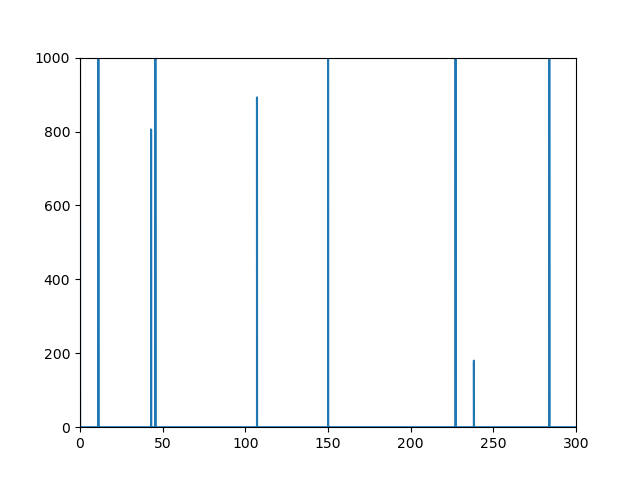

1277.7359426454032


In [81]:
frequency_range = [270,290]
index_peak_i = np.where(xf_stick >= frequency_range[0])[0][0]
index_peak_f = np.where(xf_stick >= frequency_range[1])[0][0]
max_val = max(np.real(yf_stick[index_peak_i:index_peak_f]))
min_val = min(np.real(yf_stick[index_peak_i:index_peak_f]))
plt.figure()
plt.plot(xf_stick,yf_stick)
plt.xlim(0,300)
plt.ylim(0,1000)
plt.show()
print(max_val)


### Trimming isotopomer spectra

#### For the purposes of optimization, certain isotopomers are removed, so they can be optimized individually

In [94]:
path_saved_spec = zf.select_folder()

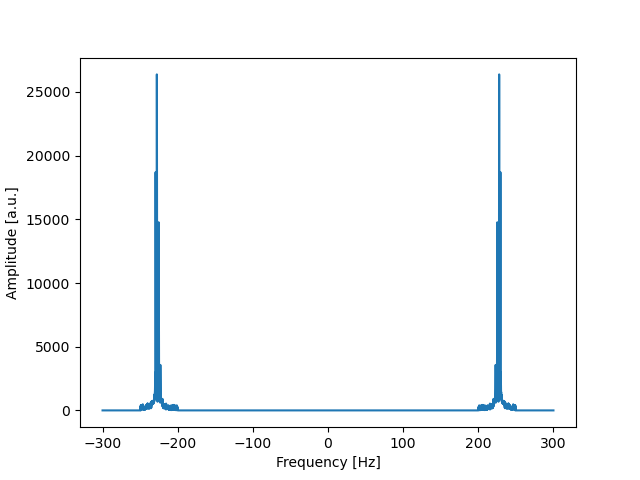

299.97555954201226
8972


In [96]:
%matplotlib widget
# Loading exp data
orig_yf = np.load(path_saved_spec+"matlab_methyl_formate_savgol_filtered_yf.npy")
orig_xf = np.load(path_saved_spec+"matlab_methyl_formate_savgol_filtered_xf.npy")

# Formatting for spinach compatbility
index_peak_i = np.where(orig_xf >= 300)[0][0]
orig_xf_trunc = orig_xf[:index_peak_i]
orig_yf_trunc = orig_yf[:index_peak_i]
index_multiplet_i = np.where(orig_xf >= 200)[0][0]
index_multiplet_f = np.where(orig_xf >= 250)[0][0]
orig_yf_trunc[:index_multiplet_i] = .0001
orig_yf_trunc[index_multiplet_f:] = .0001
orig_yf_final = np.abs(np.concatenate((np.flip(orig_yf_trunc), orig_yf_trunc)))
orig_xf_final = np.concatenate((np.flip(-1*orig_xf_trunc), orig_xf_trunc))
plt.figure()
plt.plot(orig_xf_final,orig_yf_final)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [a.u.]")
plt.show()
print(np.max(orig_xf_final))
save = True
if save:
    path_matlab = zf.select_folder()
    np.savetxt(path_matlab+"methyl_formate_CH_xf.csv",orig_xf_final,delimiter=",")
    np.savetxt(path_matlab+"methyl_formate_CH_yf.csv",orig_yf_final,delimiter=",")
print(len(orig_xf_final))